https://arxiv.org/pdf/2007.08032.pdf - main study behind this paper



In [2]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving fairface_label_test.csv to fairface_label_test.csv
Saving fairface_label_train.csv to fairface_label_train.csv
Saving fairface_label_val.csv to fairface_label_val.csv


In [3]:
if 'google.colab' in str(get_ipython()):
    print('Cloning code base to colab....')
    !git clone https://github.com/ryannguyen10/fairface.git
    !cd fairface/utils && bash train.sh
    CODE_ROOT = "fairface/"
else:
    CODE_ROOT = '..'

Cloning code base to colab....
Cloning into 'fairface'...
remote: Enumerating objects: 1587, done.
remote: Counting objects: 100% (1587/1587), done.
remote: Compressing objects: 100% (700/700), done.
remote: Total 1587 (delta 864), reused 1560 (delta 854), pack-reused 0
Receiving objects: 100% (1587/1587), 235.14 MiB | 35.04 MiB/s, done.
Resolving deltas: 100% (864/864), done.
Updating files: 100% (69/69), done.
--2023-04-04 00:15:36--  https://www.dropbox.com/s/7denxtqhqyae0c9/ezyZip.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/7denxtqhqyae0c9/ezyZip.tar.gz [following]
--2023-04-04 00:15:36--  https://www.dropbox.com/s/raw/7denxtqhqyae0c9/ezyZip.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc964426997b9e0f

In [4]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
import tqdm.notebook as tqdm
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm, classification_report as cr
from __future__ import print_function, division
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import copy
from PIL import ImageFile
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
import argparse
import pickle
import sys
sys.path.append('%s/res/'%CODE_ROOT)
from models.models import get_model
from loader.loader import get_loader
from tqdm.notebook import tqdm
from IPython.display import clear_output
sns.set_context("poster")
sns.set_palette("Set1", 8, .75)
sns.despine()

/content
/content/fairface//res/loader/loader.py
/content/fairface//res/loader


<Figure size 640x480 with 0 Axes>

In [51]:
DATASET_NAME = 'fairface'
NUM_EPOCHS = 10
BATCH_SIZE = 200
ARCH = 'LATE_BRANCHING_COMBINED'

image_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4825, 0.3579, 0.3045], std=[0.2077, 0.1805, 0.1696])
    ])

GPU = 1
NUM_CLASSES = (7,7,7,7)
loader_new = get_loader('multi_attribute_loader_file_list_mnist_rotation')

file_list_root = '%sdataset_lists'%CODE_ROOT
att_path = '%sdataset_lists/combined_attributes.p'%CODE_ROOT
shuffles = {'train':True,'val':True,'test':True}
data_dir = '%sdata/facial_image/fairface-img-margin025-trainval'%CODE_ROOT
file_lists = {}
dsets = {}
dset_loaders = {}
dset_sizes = {}
for phase in ['train','val','test']:
    file_lists[phase] = "%s/%s_list_%s.txt"%(file_list_root,phase,DATASET_NAME)
    dsets[phase] = loader_new(file_lists[phase],att_path, image_transform, data_dir)
    dset_loaders[phase] = torch.utils.data.DataLoader(dsets[phase], batch_size=BATCH_SIZE, shuffle = shuffles[phase], num_workers=2,drop_last=True)
    dset_sizes[phase] = len(dsets[phase])

In [35]:
#from torchvision import datasets, transforms

# Define a transform that normalizes the data
#transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset
#train_data = datasets.ImageFolder('/content/fairface/data/facial_image/fairface-img-margin025-trainval', transform=transform)

# Calculate mean and standard deviation
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
#mean = 0.
#std = 0.
#for images, _ in train_loader:
#    batch_samples = images.size(0)
#    images = images.view(batch_samples, images.size(1), -1)
#    mean += images.mean(2).sum(0)
#    std += images.std(2).sum(0)

#mean /= len(train_loader.dataset)
#std /= len(train_loader.dataset)

#print("Mean: ", mean)
#print("Std: ", std)

Mean:  tensor([0.4825, 0.3579, 0.3045])
Std:  tensor([0.2077, 0.1805, 0.1696])


In [38]:
multi_losses = [nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss()]
def weight_scheduler(epoch_num, task):
    if task == 'shared':
        return [0.0,1.0,0.0,1.0]
    elif task == 'gender':
        return [0.0,1.0,0.0,0.0]
    elif task == 'race':
        return [0.0,0.0,0.0,1.0]
def train_epoch(model, task, optimizer):
    model.train()
    torch.set_grad_enabled(True)
    phase = 'train'
    
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in tqdm(dset_loaders[phase]):
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())

        optimizer.zero_grad()
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]

            
            phase_epoch_loss += calculated_loss
        calculated_loss.backward()
        optimizer.step()
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Train loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]

    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'gender':
        epoch_gm = epoch_accs[1]
    elif task == 'race':
        epoch_gm = epoch_accs[3]
    
    return model, epoch_loss, epoch_gm

In [39]:
def test_epoch(model, best_model, best_test_loss, best_test_gm, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'val'
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in tqdm(dset_loaders[phase]):
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]

        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Test loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'gender':
        epoch_gm = epoch_accs[1]
    elif task == 'race':
        epoch_gm = epoch_accs[3]
    
    if epoch_loss < best_test_loss:
        best_model = model
        best_test_loss = epoch_loss
        best_test_gm = epoch_gm

    return best_model, epoch_loss, epoch_gm, best_test_loss, best_test_gm

In [40]:
def unseen_test_epoch(model, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'test'

    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in tqdm(dset_loaders[phase]):
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]


        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'gender':
        epoch_gm = epoch_accs[1]
    elif task == 'race':
        epoch_gm = epoch_accs[3]
    
    return epoch_loss, epoch_gm

In [41]:
models = {} 
models['shared']= get_model(ARCH,NUM_CLASSES)
models['gender']= get_model(ARCH,NUM_CLASSES)
models['race']= get_model(ARCH,NUM_CLASSES)

models['shared'].cuda();
models['gender'].cuda();
models['race'].cuda();

best_models = {}
best_models['shared'] = models['shared']
best_models['gender'] = models['gender']
best_models['race'] = models['race']

best_test_loss = 100
best_test_gm = 0

all_train_gms = {}
all_train_gms['shared'] = [0]
all_train_gms['separate'] = [0]

all_test_gms = {}
all_test_gms['shared'] = [0]
all_test_gms['separate'] = [0]

all_unseen_test_gms = {}
all_unseen_test_gms['shared'] = [0]
all_unseen_test_gms['separate'] = [0]

optimizers = {}
optimizers['shared'] = optim.Adam(models['shared'].parameters(), lr=0.001)
optimizers['gender'] = optim.Adam(models['gender'].parameters(), lr=0.001)
optimizers['race'] = optim.Adam(models['race'].parameters(), lr=0.001)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

Epoch: 0
---------


<ipython-input-52-d3ecc5b43398>:46: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2],     # The line objects


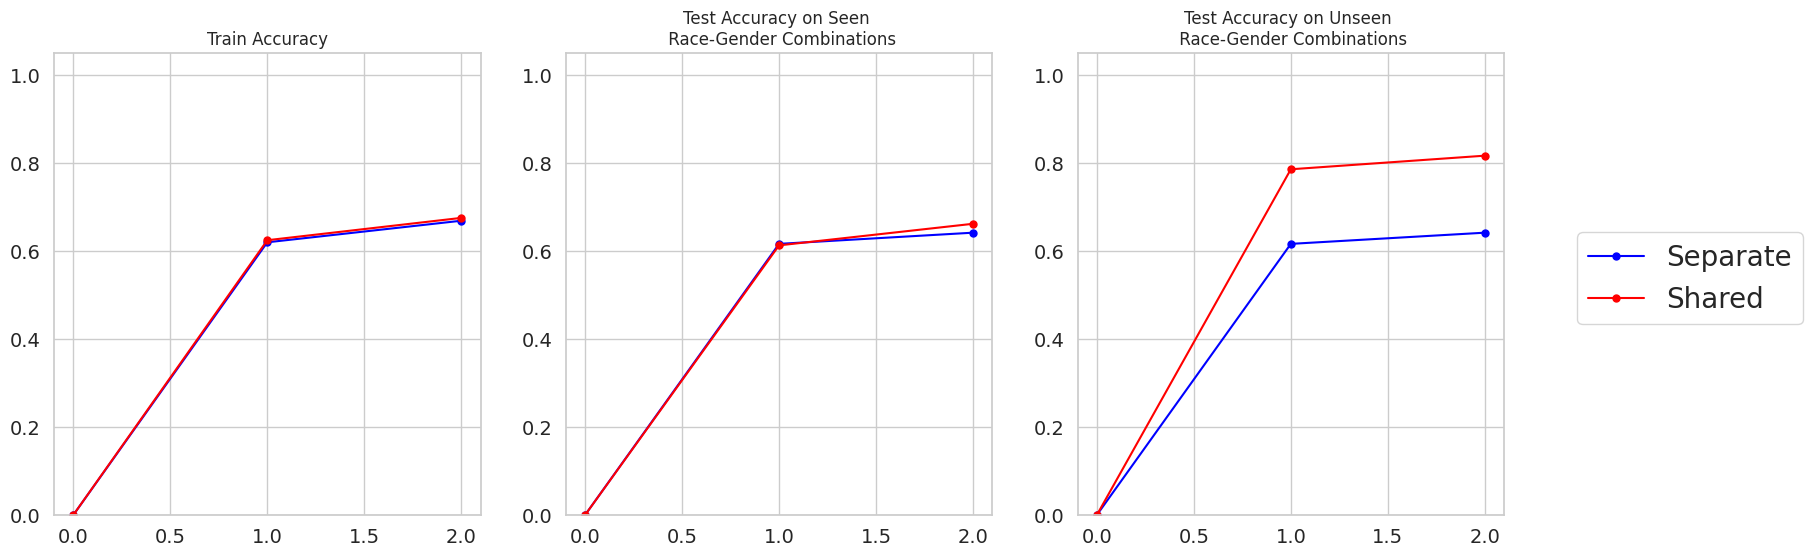

In [52]:
for epoch in range(1):
    train_gm_separate = 1
    test_gm_separate = 1
    unseen_test_gm_separate = 1

    for TASK in ['gender','race','shared']:
        print('Epoch: %s, Task: %s'%(epoch,TASK))
        print('---------')
        models[TASK], train_loss, train_gm = train_epoch(models[TASK], TASK, optimizers[TASK])
        best_models[TASK], test_loss, test_gm, best_test_loss, best_test_gm = test_epoch(models[TASK], best_models[TASK], best_test_loss, best_test_gm, TASK)
        unseen_test_loss, unseen_test_gm = unseen_test_epoch(models[TASK], TASK)

        if TASK != 'shared':
            train_gm_separate = train_gm_separate * train_gm
            test_gm_separate = test_gm_separate * test_gm
            unseen_test_gm_separate = unseen_test_gm_separate * test_gm

    all_train_gms['separate'].append(np.sqrt(train_gm_separate))
    all_test_gms['separate'].append(np.sqrt(test_gm_separate))
    all_unseen_test_gms['separate'].append(np.sqrt(unseen_test_gm_separate))
    all_train_gms['shared'].append(train_gm)
    all_test_gms['shared'].append(test_gm)
    all_unseen_test_gms['shared'].append(np.sqrt(unseen_test_gm))
    
    clear_output()
    print('Epoch: %s'%epoch)
    print('---------')
    
    line_labels = ["Separate", "Shared"]

    fig,ax = plt.subplots(1, 3, figsize=(20,6))
    l1 = ax[0].plot(all_train_gms['separate'], color = 'blue', marker = 'o', markersize=5)[0]
    l2 = ax[0].plot(all_train_gms['shared'], color = 'red', marker = 'o', markersize=5)[0]
    ax[0].set_title('Train Accuracy', fontsize=12)
    ax[0].set_ylim(0,1.05)

    ax[1].plot(all_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
    ax[1].plot(all_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
    ax[1].set_title('Test Accuracy on Seen \n Race-Gender Combinations', fontsize=12)
    ax[1].set_ylim(0,1.05)

    ax[2].plot(all_unseen_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
    ax[2].plot(all_unseen_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
    ax[2].set_ylim(0,1.05)
    ax[2].set_title('Test Accuracy on Unseen \n Race-Gender Combinations', fontsize=12)
    fig.legend([l1, l2],     # The line objects
            labels=line_labels,   # The labels for each line
            loc="center right",   # Position of legend
            borderaxespad=0.2,    # Small spacing around legend box
            prop={"size":20})
    plt.subplots_adjust(right=0.85)
    plt.show()

In [ ]:
#print(all_train_gms['shared'][8])
#print(all_train_gms['separate'][8])
#print(all_test_gms['shared'][8])
#print(all_test_gms['separate'][8])
#print(all_unseen_test_gms['shared'][8])
#print(all_unseen_test_gms['separate'][8])

In [44]:
#print(models['gender'].state_dict().keys())

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [53]:
#shared_weights = models['shared'].state_dict()
#for name, weight in shared_weights.items():
#    print(name, weight.shape)

for i in range(64):
    img = dsets[i]
    plt.imshow(img)

shared_weights = models['shared'].state_dict()
gender_weights = models['gender'].state_dict()
race_weights = models['race'].state_dict()

shared_weights = shared_weights['conv1.weight'].permute(0, 2, 3, 1).cpu().numpy()
gender_weights = gender_weights['conv1.weight'].permute(0, 2, 3, 1).cpu().numpy()
race_weights = race_weights['conv1.weight'].permute(0, 2, 3, 1).cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].imshow(shared_weights, cmap='viridis')
axs[0].set_title('Shared Weights')
axs[0].set_ylabel('Convolutional Layer 1 Weights')

axs[1].imshow(gender_weights, cmap='viridis')
axs[1].set_title('Gender Weights')

axs[2].imshow(race_weights, cmap='viridis')
axs[2].set_title('Race Weights')

plt.show()


KeyError: ignored